In [1]:
import sys
sys.path.append('./vendor/tsnmf-sparse/')

In [2]:
from tsnmf import TSNMF
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import joblib
import matplotlib as mpl
from scipy.sparse import load_npz
import ujson as json

import seaborn as sns

sns.set(style='ticks', palette='magma', context='notebook', font='Fira Sans Extra Condensed')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from runrun.utils import normalize_dataframe_rows

In [4]:
zones = gpd.read_file('json/urban_zones_2016.json').set_index('ID').to_crs({'init': 'epsg:5361'})
zones.head()

/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,AREA,Zona,Com,Comuna,area_km2,geometry
ID,,,,,,
103,837.7500,103.0,13105,El Bosque,0.457565,"MULTIPOLYGON (((346376.693 6286027.029, 346366..."
104,998.8125,104.0,13105,El Bosque,0.772546,"MULTIPOLYGON (((344151.235 6285465.040, 344263..."
106,286.2500,106.0,13105,El Bosque,2.695745,"MULTIPOLYGON (((344415.434 6285878.048, 344263..."
115,857.4375,115.0,13105,El Bosque,0.753419,"MULTIPOLYGON (((344415.434 6285878.048, 344412..."
116,853.9375,116.0,13105,El Bosque,0.718431,"MULTIPOLYGON (((345133.421 6286261.983, 345243..."


In [5]:
zone_distances = pd.read_csv('2017_results/zone_distances.csv.gz', index_col=['ZonaOrigen', 'ZonaDestino'])
zone_distances.head()

distance
ZonaOrigen ZonaDestino          
103        103          0.000000
           104          1.308764
           106          2.839237
           115          2.031142
           116          0.639319

In [6]:
zone_income = pd.read_csv('2017_results/zone_income.csv.gz', index_col='Zona')
zone_income.head()

,mean_home_income
Zona,
1,13.514147
2,13.222234
3,13.217895
4,13.436175
5,13.313145


In [7]:
zone_matrix = pd.read_json('2017_results/od_matrix_per_zone.json.gz', lines=True)
zone_matrix.head()

,dayofweek,origin_zone,destination_zone,period,trip_count
0,5,2,2,afternoon_peak,418
1,5,2,2,afternoon_valley,751
2,5,2,2,morning_valley,496
3,5,2,2,night,326
4,5,2,3,afternoon_peak,197


In [8]:
zone_matrix.dayofweek.value_counts()

3    894646
1    880716
0    868793
2    853831
5    843751
4    822784
6    739586
Name: dayofweek, dtype: int64

In [9]:
period_matrices = zone_matrix.groupby(['period', 'origin_zone', 'destination_zone'])['trip_count'].mean()

In [82]:
with open('2017_results/mnlogit_column_names.json') as f:
    mnlogit_column_names = json.load(f)
    
mnlogit_column_names

['bus',
 'intermodal_private',
 'intermodal_public',
 'non_motorized',
 'pedestrian',
 'private',
 'rail',
 'shared_taxi']

In [83]:
mnlogit = joblib.load('2017_results/trips_mnlogit_zone_model_instance.joblib.gz')
#mnlogit.summary()

In [12]:
towers =  gpd.read_file('2017_results/towers_with_labels.geo.json').set_index('tower')
towers.head()

,id,zone,municipality,name,indoor,within_metro,near_bus_corridor,near_surface_metro,near_highways,near_pedestrian_streets,near_primary_streets,near_secondary_streets,near_cycleways,near_bus_routes,near_train,near_share_taxi,geometry
tower,,,,,,,,,,,,,,,,,
11SEP,1,498,Providencia,11 de Septiembre,False,False,False,False,True,True,True,True,True,True,False,True,POINT (-70.61111 -33.42227)
BOQUF,391,498,Providencia,El Bosque 5,False,False,False,False,False,True,True,True,True,True,False,False,POINT (-70.60545 -33.41796)
CCA1A,543,498,Providencia,Mall Costanera piso 1 al interior de tienda Ri...,True,False,False,False,False,False,False,False,False,False,False,False,POINT (-70.60588 -33.41796)
CCA1B,544,498,Providencia,Mall Costanera piso 1 sector ascensores Torre 1,True,False,False,False,False,False,False,False,False,False,False,False,POINT (-70.60588 -33.41796)
CCA1C,545,498,Providencia,Mall Costanera piso 1 al interior de Supermerc...,True,False,False,False,False,False,False,False,False,False,False,False,POINT (-70.60588 -33.41796)


In [13]:
waypoints = load_npz('2017_results/waypoints_between_zones.npz')
waypoints

<1253025x1374 sparse matrix of type '<class 'numpy.int64'>'
	with 29321539 stored elements in Compressed Sparse Row format>

In [14]:
idx_to_tower = dict(zip(range(len(towers)), towers.index.values))
tower_idx = dict(zip(towers.index.values, range(len(towers))))

In [17]:
def find_tower_labels(keys):
    return set(towers[keys].sum(axis=1)
            .pipe(lambda x: x[x > 0].copy())
            .index.values)

In [48]:
rail_keys = find_tower_labels(['within_metro', 'near_surface_metro', 'near_train'])
bus_keys = find_tower_labels(['near_bus_corridor', 'near_bus_routes'])
motorized_keys = find_tower_labels(['near_highways', 'near_primary_streets', 'near_secondary_streets'])
non_motorized_keys = find_tower_labels(['near_cycleways'])
taxi_keys = find_tower_labels(['near_share_taxi'])

len(rail_keys), len(bus_keys), len(motorized_keys), len(non_motorized_keys), len(taxi_keys)

(151, 863, 862, 276, 474)

In [72]:
labeled_keys = {
    'bus': bus_keys, # - (motorized_keys | rail_keys),
    'rail': rail_keys, # - (bus_keys | motorized_keys),
    'private': motorized_keys, # - (bus_keys | taxi_keys | rail_keys | non_motorized_keys),
    'shared_taxi': taxi_keys, # - (motorized_keys | rail_keys | non_motorized_keys) 
    'non_motorized': non_motorized_keys# - (bus_keys | rail_keys | motorized_keys | pedestrian)
}

list(map(len, labeled_keys.values()))

[863, 151, 862, 474, 276]

In [84]:
topic_ids = dict(zip(labeled_keys.keys(), range(len(labeled_keys))))
topic_ids

labels = []
for idx in tower_idx:
    #print(idx)
    tower_label = []
    for topic_name, topic_id in topic_ids.items():
        if idx in labeled_keys[topic_name]:
            tower_label.append(topic_id)
    labels.append(tower_label)
    
len(list(filter(lambda x: x, labels)))

1057

In [53]:
waypoint_index = pd.read_json('2017_results/waypoints_between_zones_index.json.gz', lines=True)
waypoint_index.head()

,index,origin_zone,destination_zone,period
0,0,2,2,afternoon_peak
1,1,2,2,afternoon_valley
2,2,2,2,morning_peak_1
3,3,2,2,morning_peak_2
4,4,2,2,morning_valley


In [54]:
periods = waypoint_index.period.unique()
periods

array(['afternoon_peak', 'afternoon_valley', 'morning_peak_1',
       'morning_peak_2', 'morning_valley', 'night', 'night_valley'],
      dtype=object)

In [55]:
relevant_periods = ['morning_peak_2', 'afternoon_peak']

In [56]:
period = 'morning_peak_2'

In [57]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize, MinMaxScaler

sup_min_bubble_size = 0
sup_max_bubble_size = 70

def plot_component(column, **kwargs):
    df = kwargs.pop('data')
    ax = plt.gca()
    #urban_context.plot(ax=ax, facecolor='#efefef', edgecolor='#cfcfcf')
    #highways.plot(ax=ax, color='#333333', linewidth=1)
    #primary.plot(ax=ax, color='orange', linewidth=1)
    #cycleways.plot(ax=ax, color='lime', linewidth=1)

    scaler = kwargs.pop('scaler', None)
    sizes = scaler.transform(np.sqrt(df[column].values.reshape(-1, 1)))
    ax.scatter(df.geometry.x, df.geometry.y, s=sizes, color='#4B0082', alpha=0.5, zorder=20)
    plt.axis('off')
    plt.axis('equal')

In [58]:
waypoint_index[waypoint_index.period == period].index

Int64Index([      3,      10,      17,      24,      31,      39,      46,
                 53,      60,      67,
            ...
            1252959, 1252966, 1252972, 1252979, 1252986, 1252993, 1253000,
            1253007, 1253014, 1253021],
           dtype='int64', length=168245)

In [75]:
waypoint_periods = waypoint_index[waypoint_index.period == period]
# we use a binary matrix this time! we are interested in routes, not in magnitudes
to_factorize = csr_matrix(TfidfTransformer(norm='l1').fit_transform(waypoints[waypoint_periods.index]).T, copy=True)

In [76]:
zone_features = (waypoint_periods
    .join(zone_income, on='origin_zone', how='inner')
    .rename(columns={'mean_home_income': 'origin_income'})
    .join(zone_income, on='destination_zone', how='inner')
    .rename(columns={'mean_home_income': 'destination_income'})
    .join(zone_distances, on=['origin_zone', 'destination_zone'], how='inner')
)
zone_features.head()

,index,origin_zone,destination_zone,period,origin_income,destination_income,distance
3,3,2,2,morning_peak_2,13.222234,13.222234,0.000000
2515,2515,3,2,morning_peak_2,13.217895,13.222234,0.528420
5426,5426,4,2,morning_peak_2,13.436175,13.222234,0.608068
8246,8246,5,2,morning_peak_2,13.313145,13.222234,0.792931
11029,11029,6,2,morning_peak_2,13.034107,13.222234,1.276030


In [77]:
# perform the factorization
nmf = TSNMF(n_components=len(topic_ids), init='random', verbose=1, tol=1e-02, max_iter=5, random_state=42)
W = nmf.fit_transform(to_factorize, labels)

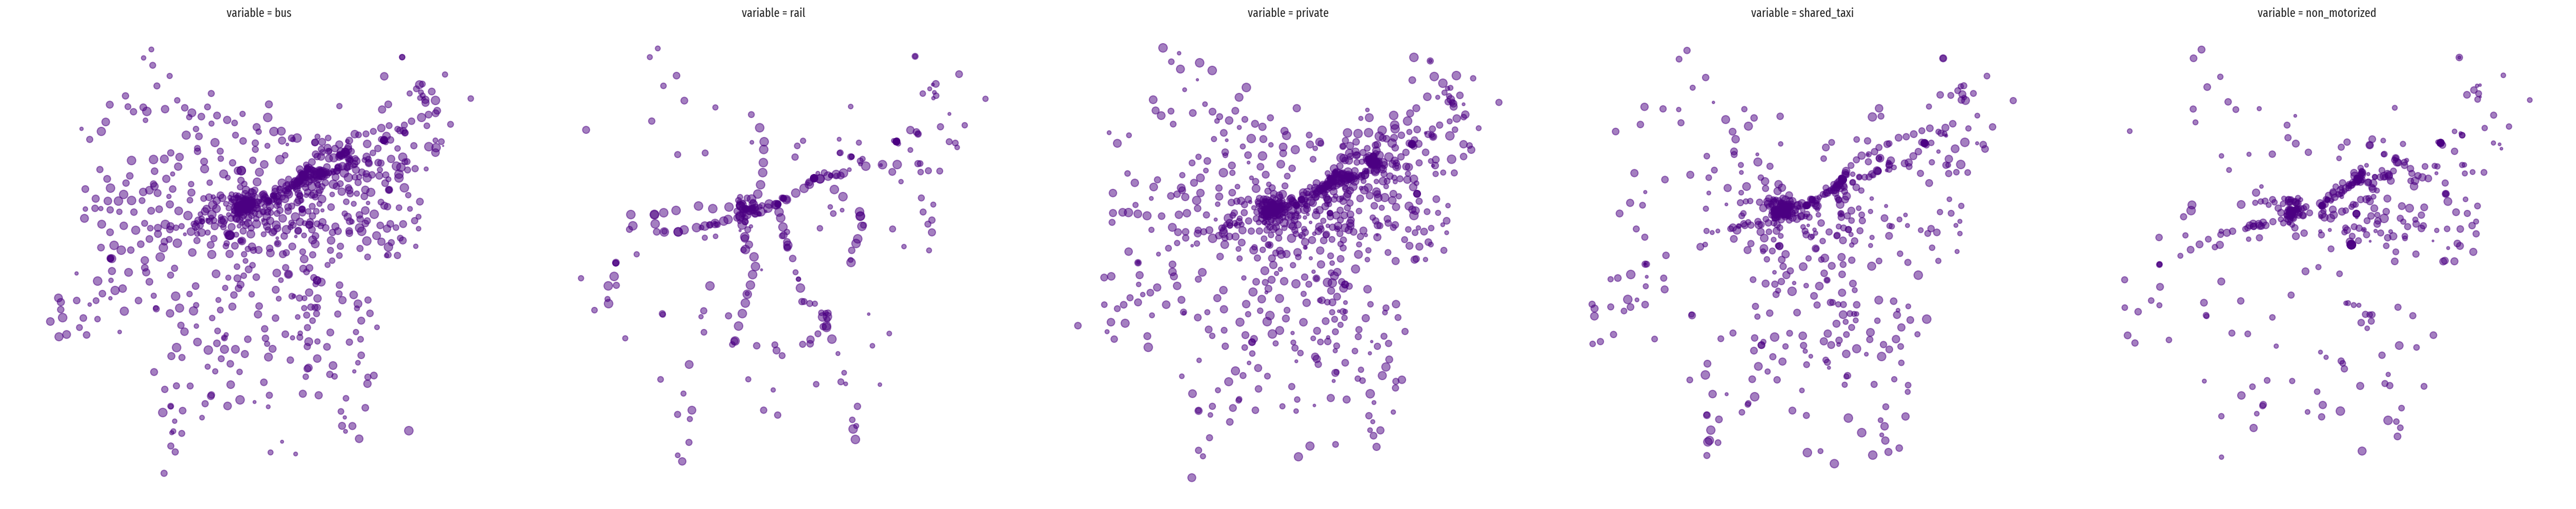

In [78]:
tower_mode = pd.DataFrame(normalize(W, norm='l1').todense(), index=towers.index.tolist(), columns=labeled_keys.keys())
tower_mode.index.name = 'tower'

# plot the tower factorization for inspection
sup_tower_components = (tower_mode
                        .reset_index()
                        .pipe(lambda x: pd.melt(x, id_vars='tower')))

sup_scaler = MinMaxScaler(feature_range=(sup_min_bubble_size, sup_max_bubble_size))
sup_scaler.fit(np.sqrt(sup_tower_components.value.values.reshape(-1, 1)))

sup_geodf = gpd.GeoDataFrame(sup_tower_components.join(towers, on='tower'), crs={'init': 'epsg:4326'})

g = sns.FacetGrid(data=sup_geodf, col='variable', height=7, aspect=1, sharex=False, sharey=False)
g.map_dataframe(plot_component, 'value', scaler=sup_scaler)

In [79]:
# retrieve the zone-mode matrix
flow_mode = (pd.DataFrame(nmf.components_.T.todense(), 
                          index=waypoint_periods.index, 
                          columns=labeled_keys.keys())
             .join(waypoint_periods)
             .set_index(['origin_zone', 'destination_zone'])
             .drop(['index', 'period'], axis=1)
)

flow_mode.head()

bus      rail   private  shared_taxi  \
origin_zone destination_zone                                              
2           2                 0.000777  0.005529  0.021878     0.001363   
            3                 0.002282  0.004643  0.019511     0.011274   
            4                 0.024533  0.002708  0.000181     0.015897   
            5                 0.016491  0.008337  0.011360     0.003846   
            6                 0.011492  0.002003  0.013011     0.009037   

                              non_motorized  
origin_zone destination_zone                 
2           2                      0.019285  
            3                      0.020531  
            4                      0.013052  
            5                      0.004972  
            6                      0.013114

In [80]:
# estimate a probability for pedestrian trips.
# we use a logistic function. the 0.5 prob for non motorized trips is assigned at 500 meters.
pedestrian_p = 1 - 1 / (1 + np.exp(-(zone_distances.loc[flow_mode.index].distance - 0.25)))
pedestrian_p.name = 'pedestrian'

In [93]:
# build the evidence matrix with with the zone-mode matrix and non-motorized probabilities
flow_evidence = (flow_mode
                  .pipe(normalize_dataframe_rows)
                  .mul(1 - pedestrian_p.values, axis='rows')
                  .assign(pedestrian=pedestrian_p.values)
)

for col in mnlogit_column_names:
    if not col in flow_evidence:
        flow_evidence[col] = 0

flow_evidence = flow_evidence[mnlogit_column_names]
flow_evidence.head()

bus  intermodal_private  intermodal_public  \
origin_zone destination_zone                                                    
2           2                 0.006969                   0                  0   
            3                 0.022302                   0                  0   
            4                 0.256151                   0                  0   
            5                 0.231759                   0                  0   
            6                 0.173857                   0                  0   

                              non_motorized  pedestrian   private      rail  \
origin_zone destination_zone                                                  
2           2                      0.172910    0.562177  0.196154  0.049570   
            3                      0.200639    0.430841  0.190670  0.045371   
            4                      0.136280    0.411427  0.001885  0.028276   
            5                      0.069875    0.367506  0.159641  0.117166   
            6                      0.198402    0.263854  0.196852  0.030309   

                              shared_taxi  
origin_zone destination_zone               
2           2                    0.012221  
            3                    0.110176  
            4                    0.165980  
            5                    0.054052  
            6                    0.136725

In [100]:
pd.__version__

'1.0.3'

In [103]:
# to ensure that we use only zones with prior information
flow_evidence = flow_evidence.loc[zone_features.set_index(['origin_zone', 'destination_zone']).index]
flow_evidence.head()

,,bus,intermodal_private,intermodal_public,non_motorized,pedestrian,private,rail,shared_taxi
origin_zone,destination_zone,,,,,,,,
2,2,0.006969,0,0,0.172910,0.562177,0.196154,0.049570,0.012221
3,2,0.107731,0,0,0.301563,0.430841,0.070219,0.035434,0.054212
4,2,0.072893,0,0,0.282352,0.411427,0.118768,0.008677,0.105882
5,2,0.102805,0,0,0.222578,0.367506,0.084740,0.035967,0.186404
6,2,0.396802,0,0,0.034433,0.263854,0.106508,0.020727,0.177675


In [104]:
flow_evidence.shape

(156428, 8)

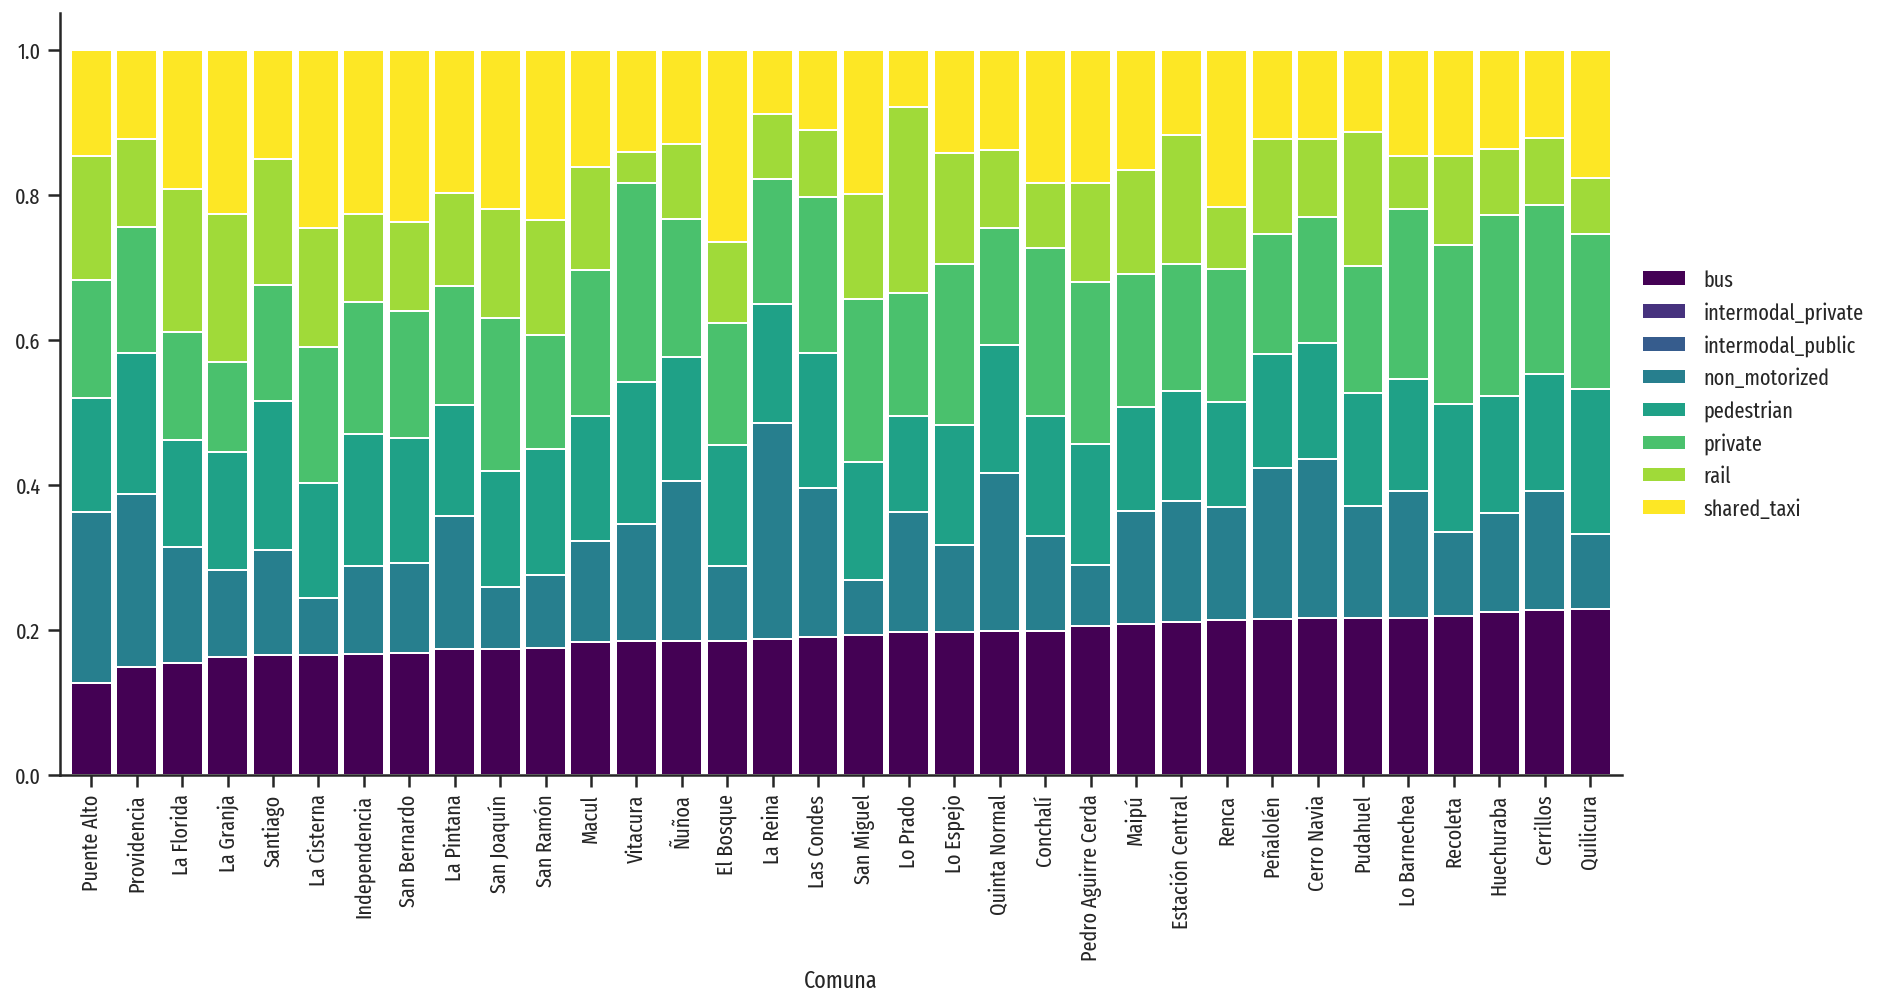

In [110]:
# plot the evidence modal partition for inspection
flow_evidence_trips = flow_evidence.mul(period_matrices.loc[period], axis='index')

(flow_evidence_trips
 .join(zones.Comuna, on='origin_zone')
 .groupby('Comuna')
 .sum()
 .pipe(normalize_dataframe_rows)
 .sort_values('bus')
 .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
sns.despine()

In [107]:
# estimate the prior information using the EOD mnlogit model
zone_priors = mnlogit.predict(zone_features.set_index(['origin_zone', 'destination_zone']))
zone_priors.columns = mnlogit_column_names
flow_priors = zone_priors.loc[flow_evidence.index]

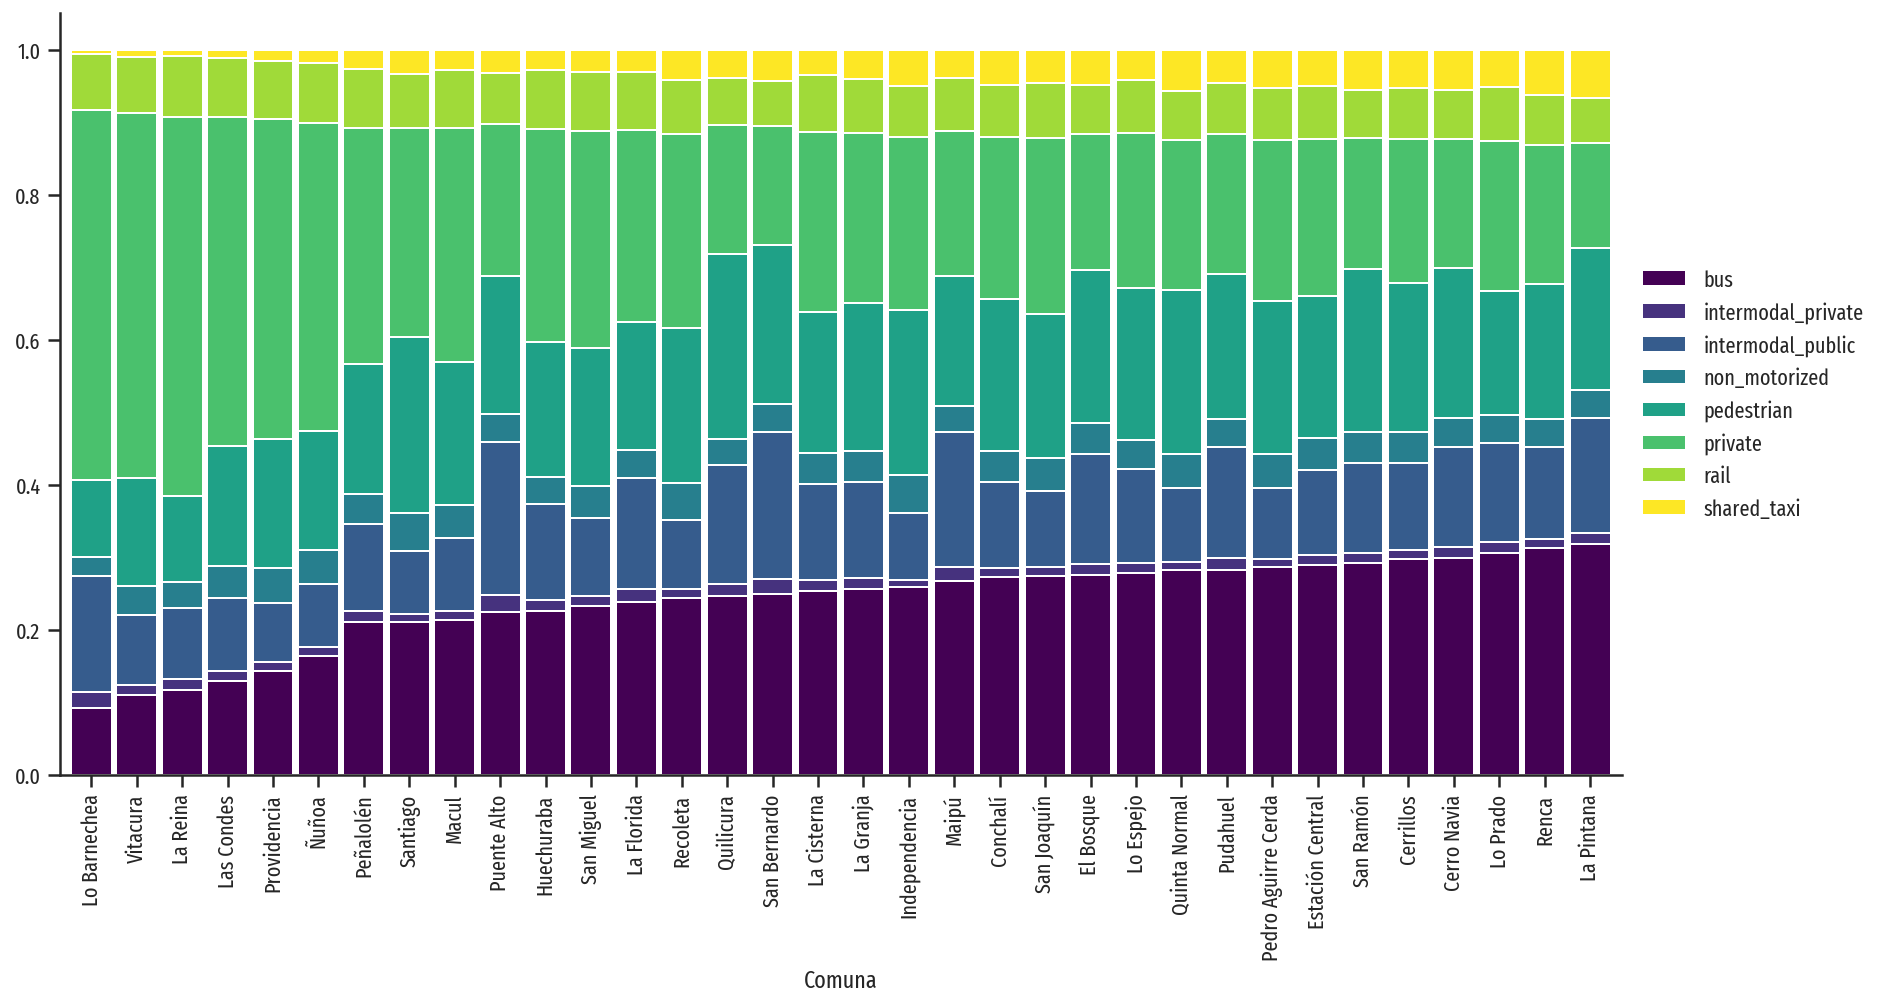

In [109]:
# plot the prior partition for inspection
flow_prior_trips = flow_priors.mul(period_matrices.loc[period], axis='index')

(flow_prior_trips
 .join(zones.Comuna, on='origin_zone')
 .groupby('Comuna')
 .sum()
 .pipe(normalize_dataframe_rows)
 .sort_values('bus')
 .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
sns.despine()

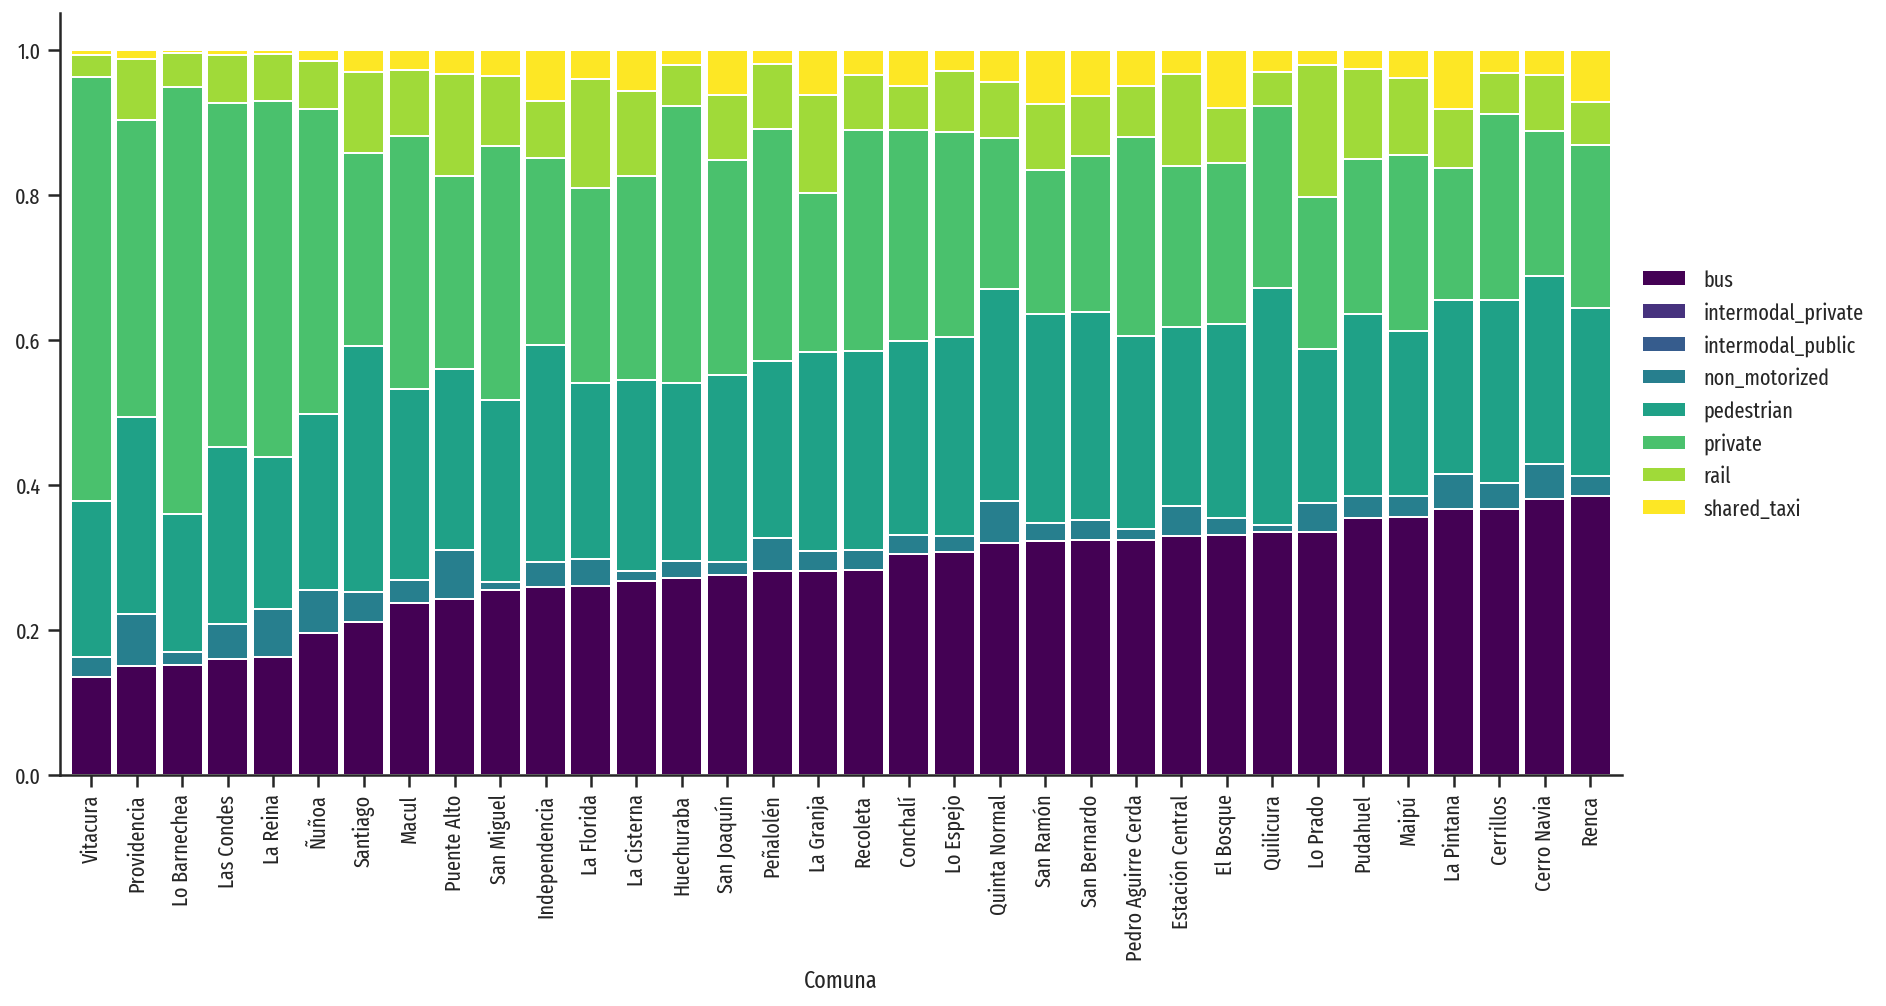

In [112]:
# use bayes theorem to estimate the posterior modal partition
denominator = flow_priors.mul(flow_evidence).sum(axis=1)
flow_posteriors = flow_evidence.mul(flow_priors).div(denominator, axis='index')

# plot the posterior partition for inspection
flow_trips = flow_posteriors.mul(period_matrices.loc[period], axis='index')

(flow_trips
 .join(zones.Comuna, on='origin_zone')
 .groupby('Comuna')
 .sum()
 .pipe(normalize_dataframe_rows)
 .sort_values('bus')
 .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
sns.despine()